<a href="https://colab.research.google.com/github/MAYANK12-WQ/ml-house-price-predictor/blob/main/HousePro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np                # For numerical operations
import pandas as pd               # For data manipulation
import matplotlib.pyplot as plt   # For static visualizations
import seaborn as sns             # For prettier visualizations
import plotly.express as px       # For interactive plots
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('house_prices.csv')

In [3]:
print("Shape of the dataset:", df.shape)
df.head()

Shape of the dataset: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,N,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,N,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,N,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,N,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,N,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


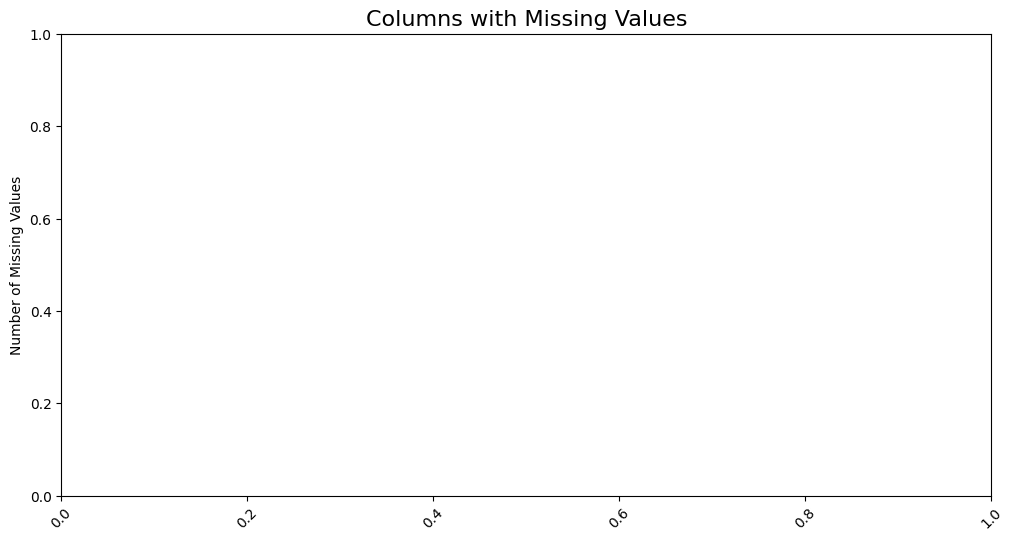

In [4]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=missing.index, y=missing.values, palette="rocket")
plt.xticks(rotation=45)
plt.title("Columns with Missing Values", fontsize=16)
plt.ylabel("Number of Missing Values")
plt.show()

In [5]:
# Check data types
df.dtypes


,0
id,int64
date,object
price,float64
bedrooms,int64
bathrooms,float64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,object
view,int64


In [6]:
# Unique values per column
unique_vals = df.nunique().sort_values()
print("Unique values per column:")
print(unique_vals)

Unique values per column:
waterfront           2
view                 5
condition            5
floors               6
grade               12
bedrooms            13
bathrooms           30
zipcode             70
yr_renovated        70
yr_built           116
sqft_basement      306
date               372
long               752
sqft_living15      777
sqft_above         946
sqft_living       1038
price             4028
lat               5034
sqft_lot15        8689
sqft_lot          9782
id               21436
dtype: int64


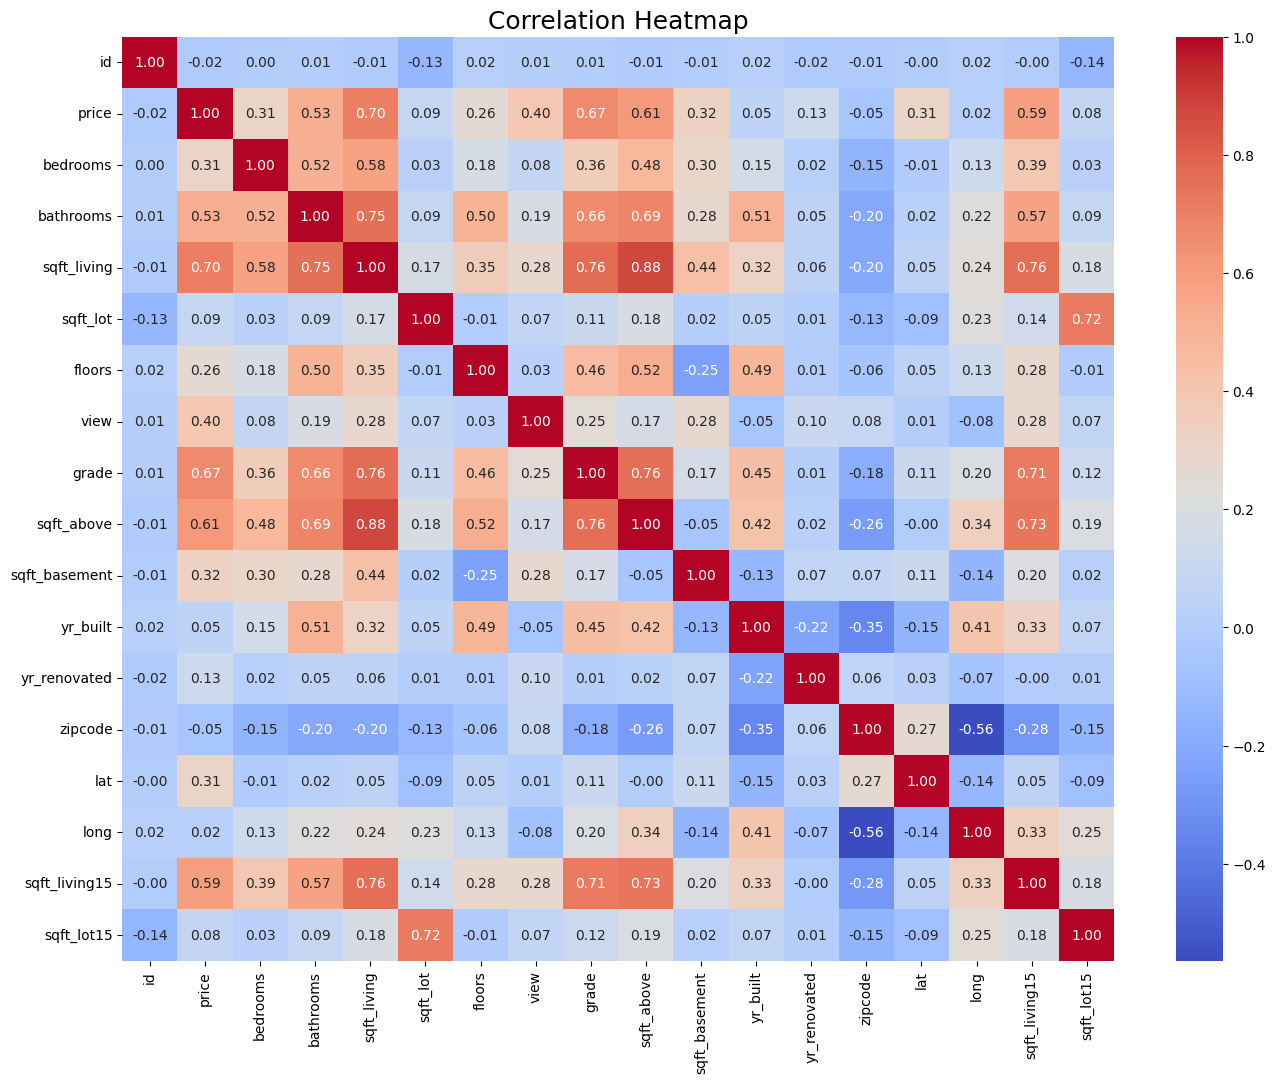

In [7]:
plt.figure(figsize=(16, 12))
corr = df.corr(numeric_only=True)  # safe for non-numeric cols
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap", fontsize=18)
plt.show()


In [8]:
# Drop columns that do not help with prediction
df.drop(columns=["id", "date", "zipcode", "lat", "long"], inplace=True)


In [9]:
print("Duplicate entries:", df.duplicated().sum())
df = df.drop_duplicates()


Duplicate entries: 6


In [10]:
# Add house age
df["house_age"] = 2025 - df["yr_built"]

# Flag: was the house renovated?
df["was_renovated"] = df["yr_renovated"].apply(lambda x: 1 if x > 0 else 0)

# Total usable square footage
df["total_sqft"] = df["sqft_above"] + df["sqft_basement"]

# Drop old columns that are now captured by new features
df.drop(columns=["yr_built", "yr_renovated", "sqft_above", "sqft_basement"], inplace=True)


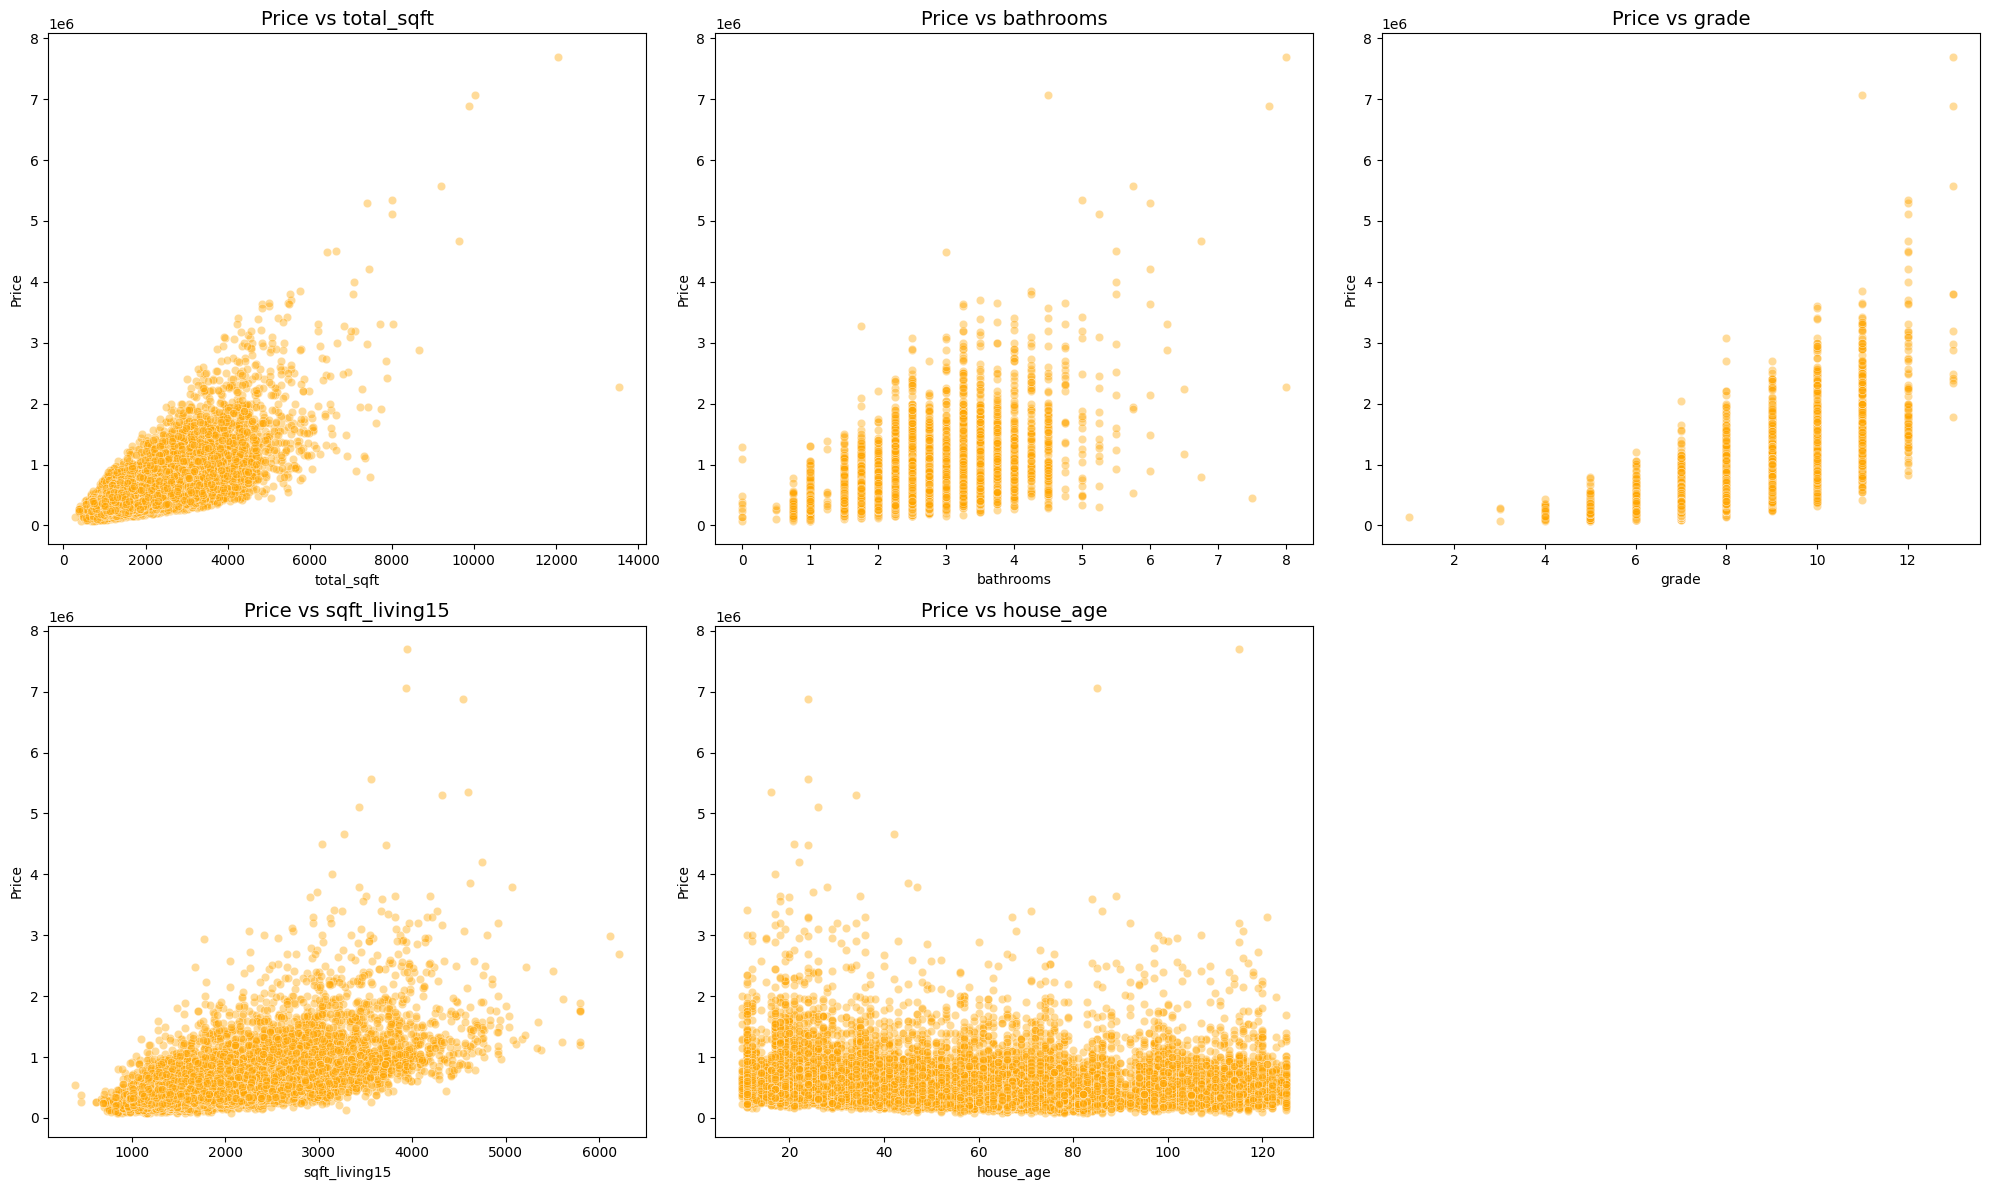

In [11]:
# Features with high correlation to price
top_features = ["price", "total_sqft", "bathrooms", "grade", "sqft_living15", "house_age"]

# Beautiful visual storytelling
plt.figure(figsize=(20, 12))
for i, col in enumerate(top_features[1:], 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=col, y="price", alpha=0.4, color="orange")
    plt.title(f"Price vs {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Price")

plt.tight_layout()
plt.show()


In [12]:
# Separate the target variable
X = df.drop("price", axis=1)
y = df["price"]


In [13]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Check for non-numeric columns
print(X.dtypes[X.dtypes == 'object'])


waterfront    object
condition     object
dtype: object


In [16]:
from sklearn.preprocessing import LabelEncoder

# Create a copy to avoid modifying the original
X_encoded = X.copy()

# Apply LabelEncoder to object columns
label_encoder = LabelEncoder()
for col in X_encoded.columns:
    if X_encoded[col].dtype == 'object':
        X_encoded[col] = label_encoder.fit_transform(X_encoded[col])


In [17]:
# Redo split with encoded data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale it again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R² Score:", r2_score(y_test, y_pred_lr))


Linear Regression Performance:
MAE: 142115.01516781087
MSE: 48453641809.15788
RMSE: 220121.8794421806
R² Score: 0.6597372889918682


In [21]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
print("Random Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R² Score:", r2_score(y_test, y_pred_rf))


Random Forest Performance:
MAE: 115297.79965411185
MSE: 34213098562.8573
RMSE: 184967.83115681846
R² Score: 0.7597406255893447


In [22]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test, y=y_pred_rf,
    mode='markers',
    marker=dict(color='orange', size=6),
    name='Predicted vs Actual'
))

fig.add_trace(go.Scatter(
    x=y_test, y=y_test,
    mode='lines',
    line=dict(color='green', dash='dash'),
    name='Ideal Prediction Line'
))

fig.update_layout(
    title="📈 Actual vs Predicted House Prices (Random Forest)",
    xaxis_title="Actual Price",
    yaxis_title="Predicted Price",
    template="plotly_white",
    height=600
)

fig.show()


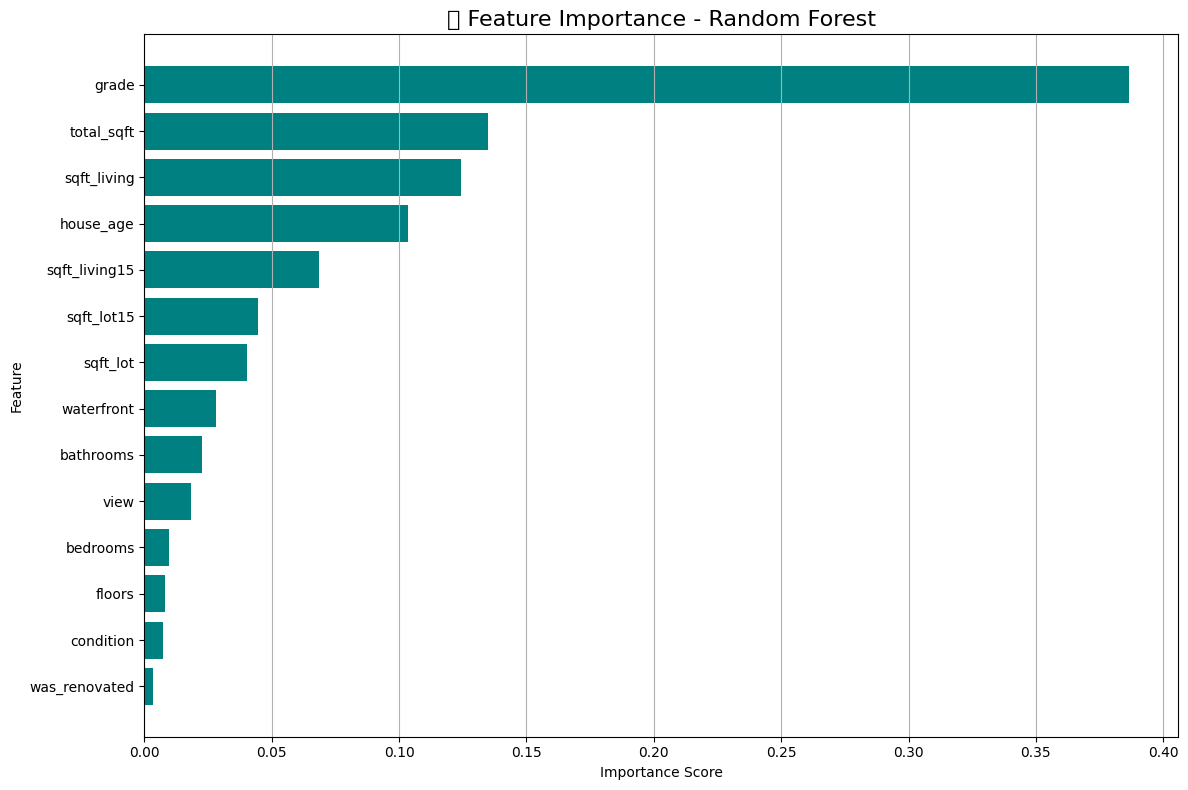

In [23]:
importances = rf_model.feature_importances_
features = X_encoded.columns

# Sort features by importance
sorted_idx = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.barh(features[sorted_idx], importances[sorted_idx], color='teal')
plt.title("💡 Feature Importance - Random Forest", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [24]:
from xgboost import XGBRegressor

# Train the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
print("XGBoost Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("MSE:", mean_squared_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R² Score:", r2_score(y_test, y_pred_xgb))


XGBoost Performance:
MAE: 117709.6598760701
MSE: 34654047179.38206
RMSE: 186155.9754060612
R² Score: 0.7566440911272924


In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Best model
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test_scaled)

# Evaluate
print("🎯 Tuned XGBoost Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_best_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best_xgb)))
print("R² Score:", r2_score(y_test, y_pred_best_xgb))


Fitting 3 folds for each of 18 candidates, totalling 54 fits
🎯 Tuned XGBoost Performance:
MAE: 116624.56768784705
RMSE: 185427.45827678047
R² Score: 0.7585450995652814


In [26]:
def get_renovation_advice(row):
    suggestions = []

    # Grade-related suggestion
    if row['grade'] <= 6:
        suggestions.append("Consider upgrading interior finishings to improve the grade.")

    # House age suggestion
    if row['house_age'] > 30:
        suggestions.append("House is old. Recommend full or partial renovation.")

    # Living space improvement
    if row['total_sqft'] < 1500:
        suggestions.append("Expand the property to increase total living area.")

    # Bathroom suggestions
    if row['bathrooms'] < 2:
        suggestions.append("Add an additional bathroom to increase value.")

    return suggestions


In [27]:
# Apply renovation suggestion logic
df['renovation_advice'] = df.apply(get_renovation_advice, axis=1)

# Show a few results
df[['price', 'grade', 'house_age', 'total_sqft', 'bathrooms', 'renovation_advice']].head(10)


,price,grade,house_age,total_sqft,bathrooms,renovation_advice
0,221900.0,7,70,1180,1.00,[House is old. Recommend full or partial renov...
1,538000.0,7,74,2570,2.25,[House is old. Recommend full or partial renov...
2,180000.0,6,92,770,1.00,[Consider upgrading interior finishings to imp...
3,604000.0,7,60,1960,3.00,[House is old. Recommend full or partial renov...
4,510000.0,8,38,1680,2.00,[House is old. Recommend full or partial renov...
5,1225000.0,11,24,5420,4.50,[]
6,257500.0,7,30,1715,2.25,[]
7,291850.0,7,62,1060,1.50,[House is old. Recommend full or partial renov...
8,229500.0,7,65,1780,1.00,[House is old. Recommend full or partial renov...
9,323000.0,7,22,1890,2.50,[]


In [29]:
# Create a test set copy
df_test = X_test.copy()
df_test['actual_price'] = y_test
df_test['predicted_price'] = y_pred_best_xgb

# Optional: Bring back renovation advice (match columns)
df_test['renovation_advice'] = df.loc[df_test.index, 'renovation_advice']

# Select final columns to display
summary_df = df_test[['actual_price', 'predicted_price', 'grade', 'total_sqft', 'house_age', 'bathrooms', 'renovation_advice']]
summary_df.head(10)


,actual_price,predicted_price,grade,total_sqft,house_age,bathrooms,renovation_advice
9399,879000.0,837644.06250,10,3590,20,3.00,[]
18667,526500.0,405669.18750,7,1310,97,1.50,[House is old. Recommend full or partial renov...
9996,262000.0,333376.78125,7,1700,63,1.50,[House is old. Recommend full or partial renov...
10973,595000.0,474669.62500,7,1280,72,1.75,[House is old. Recommend full or partial renov...
3043,430000.0,274072.43750,6,990,94,1.00,[Consider upgrading interior finishings to imp...
2199,347000.0,481667.46875,8,2770,36,2.50,[House is old. Recommend full or partial renov...
5734,400000.0,394795.25000,7,2170,45,2.50,[House is old. Recommend full or partial renov...
12700,515000.0,514568.50000,8,2600,22,2.50,[]
2323,552500.0,445988.37500,7,1430,76,1.00,[House is old. Recommend full or partial renov...
16413,760000.0,999824.62500,10,3720,21,3.50,[]


In [30]:
summary_df.to_csv("final_house_price_summary.csv", index=False)


In [32]:
import joblib
joblib.dump(best_xgb, 'best_xgboost_model.pkl')


['best_xgboost_model.pkl']

In [33]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00


In [37]:
# 🛠️ FIXED House Price Chatbot with Full Feature Alignment

def house_chatbot_fixed():
    print("🏠 Welcome to the House Price Advisor Bot!")
    print("You can type details like:")
    print(" - 'predict price for grade 7, 1800 sqft, 20 years old, 2 bathrooms'")
    print(" - 'should I renovate a house that's 70 years old with grade 6?'")
    print("Type 'exit' to quit.\n")

    while True:
        user_input = input("👤 You: ")

        if user_input.lower() == "exit":
            print("🤖 Bot: Goodbye! Stay smart with your real estate choices.")
            break

        try:
            import re
            numbers = [float(x) for x in re.findall(r'\d+(?:\.\d+)?', user_input)]

            if "predict" in user_input.lower():
                if len(numbers) < 4:
                    print("🤖 Bot: Please provide at least grade, sqft, age, and bathrooms.")
                    continue

                grade, total_sqft, house_age, bathrooms = numbers[:4]

                # Create a full row with all required columns
                input_data = {
                    'grade': grade,
                    'total_sqft': total_sqft,
                    'house_age': house_age,
                    'bathrooms': bathrooms,
                    # Fill rest with typical values (or medians)
                    'sqft_living': 1800,
                    'sqft_lot': 7500,
                    'sqft_living15': 1600,
                    'sqft_lot15': 7500,
                    'view': 0,
                    'bedrooms': 3,
                    'floors': 1,
                    'condition': 3,
                    'waterfront': 0,
                    'was_renovated': 0
                }

                # Ensure order matches training columns
                input_df = pd.DataFrame([input_data])[X_train.columns]

                # Scale
                input_scaled = scaler.transform(input_df)

                # Predict
                predicted_price = best_xgb.predict(input_scaled)[0]
                print(f"🤖 Bot: Estimated price is ₹{int(predicted_price):,}")

            elif "renovate" in user_input or "should i" in user_input.lower():
                house_age = int(numbers[0]) if numbers else 50
                grade = int(re.search(r'grade\s*(\d+)', user_input).group(1)) if 'grade' in user_input else 6

                if house_age > 50 or grade < 7:
                    print("🤖 Bot: House is old or low grade. Recommend renovation ✅")
                else:
                    print("🤖 Bot: House is in good shape. No renovation needed 🎉")

            else:
                print("🤖 Bot: Sorry, I didn't understand that. Try asking again.")

        except Exception as e:
            print(f"🤖 Bot: Oops! Something went wrong: {e}")


In [ ]:
house_chatbot_fixed()


🏠 Welcome to the House Price Advisor Bot!
You can type details like:
 - 'predict price for grade 7, 1800 sqft, 20 years old, 2 bathrooms'
 - 'should I renovate a house that's 70 years old with grade 6?'
Type 'exit' to quit.

👤 You: predict price for grade 7, 1800 sqft, 20 years old, 2 bathroom
🤖 Bot: Estimated price is ₹269,316
👤 You: cool should I renovate a house that's 70 years old with grade 6?'
🤖 Bot: House is old or low grade. Recommend renovation ✅
